<a href="https://colab.research.google.com/github/kaljuvee/datascience/blob/master/notebooks/news/news_sentiment_longshort_vxrt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## News Sentiment Based Long-Short Trading Strategy - Vaxart Inc (NASDAQ:VXRT)

###### Load dependency libraries 

In [1]:
!pip install feedparser
!pip install textblob
!pip install arrow
!pip3 install yfinance --upgrade --no-cache-dir
!pip install vaderSentiment
import yfinance as yf
import pandas as pd
import numpy as np
import feedparser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 194kB 7.0MB/s 
  Created wheel for feedparser: filename=feedparser-5.2.1-cp36-none-any.whl size=44940 sha256=a391fb43a1447542df92ccadb36354d07163ab91eca8d31c78a89e83da14437f
  Stored in directory: /root/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
Successfully built feedparser
     |████████████████████████████████| 51kB 3.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=28ce792d1f51eeb4d82805325c6408155e80ac16e01797b34fc4cda34268f74f
  Stored in directory: /tmp/pip-ephem-wheel-cache-iepf2ukq/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance
     |████████████████████████████████| 133kB 8.0MB/s 


**News Sentiment Trading - Long / Short**

**Pipeline:**
1. **Fetch news** - read in news source via an RSS feed (Feedparser)
2. **Assign sentiment score** - assign sentiment score (Vader and TextBlob)
6. **Historical EOD prices** - fetch historical prices (Yfinance)
6. **Backtesting - Calculate PnL** - back test for PnL performance

**Strategy:**
* **Positive News Sentiment** - if market opens on positive news, short the stock from market open to market close 
* **Negative News Sentiment** - if market opens on negative news, go long - buy on open, sell on close

See more at:
*   https://www.altsignals.ai







### **1. Fetch News from RSS Feed**

In [2]:
from bs4 import BeautifulSoup

def clean_text(raw_html):
  cleantext = BeautifulSoup(raw_html, "lxml").text
  return cleantext

symbol = 'VXRT'
company = 'Vaxart Inc'
rss_url = 'https://www.globenewswire.com/RssFeed/Organization/dqKTlO0WKWyA0lN-FU6zhA=='
cols = ['ticker', 'company', 'title', 'summary', 'published', 'link', 'sentiment', 'shares', 'price_sensi', 'begin_price', 'end_price', 'side', 'cumpnl', 'pnl', 'strategy']

news_df = pd.DataFrame(columns = cols)
feed = feedparser.parse(rss_url )

for newsitem in feed['items']:
    news_df = news_df.append({'title': newsitem['title'], 
                      'summary': clean_text(newsitem['summary']), 
                      'published': newsitem['published'], 
                      'link': newsitem['link']}, ignore_index=True)
news_df

,ticker,company,title,summary,published,link,sentiment,shares,price_sensi,begin_price,end_price,side,cumpnl,pnl,strategy
0,NaN,NaN,Vaxart’s COVID-19 Vaccine Selected for the U.S...,OWS to Test First Oral COVID-19 Vaccine in Non...,"Fri, 26 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,"Vaxart, Inc. Signs Memorandum of Understanding...",Enabling Production of A Billion or More COVID...,"Thu, 25 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,"Vaxart, Inc. Set to Join Russell 3000® Index","SOUTH SAN FRANCISCO, Calif., June 24, 2020 (...","Wed, 24 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,"Vaxart, Inc. to Present at the H.C. Wainwright...",Live Webcast on Thursday June 25th at 10:25 am...,"Tue, 23 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,"Vaxart, Inc. Appoints New CEO to Accelerate Ad...",Andrei Floroiu Appointed Chief Executive Offic...,"Mon, 15 Jun 2020 11:30 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,Vaxart to Present at the Jefferies Virtual He...,"SOUTH SAN FRANCISCO, Calif., June 03, 2020 (...","Wed, 03 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,Vaxart Announces Selection of its Oral COVID-1...,KindredBio Selected as Second Contract Manufac...,"Wed, 20 May 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,Vaxart Announces First Quarter 2020 Financial ...,Lead Vaccine Candidates for COVID-19 are Highl...,"Tue, 12 May 2020 20:01 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,Vaxart Announces Additional Positive Pre-Clini...,Robust Boosting of Immune Responses Observed a...,"Thu, 30 Apr 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,Vaxart Announces Corporate Update for First Qu...,Preparations for the Manufacturing of GMP Vacc...,"Tue, 28 Apr 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **2. Assign Sentiment Score**

In [4]:
from textblob import TextBlob

# Sentiment score from TextBlob
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Sentiment score from Vader
def get_vader_sentiment(txt):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(txt)
    return vs['compound']

news_df['sentiment'] = news_df['summary'].apply(lambda x : (get_vader_sentiment(x) + get_textblob_sentiment(x))/2)
news_df

,ticker,company,title,summary,published,link,sentiment,shares,price_sensi,begin_price,end_price,side,cumpnl,pnl,strategy
0,NaN,NaN,Vaxart’s COVID-19 Vaccine Selected for the U.S...,OWS to Test First Oral COVID-19 Vaccine in Non...,"Fri, 26 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,"Vaxart, Inc. Signs Memorandum of Understanding...",Enabling Production of A Billion or More COVID...,"Thu, 25 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,"Vaxart, Inc. Set to Join Russell 3000® Index","SOUTH SAN FRANCISCO, Calif., June 24, 2020 (...","Wed, 24 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.538350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,"Vaxart, Inc. to Present at the H.C. Wainwright...",Live Webcast on Thursday June 25th at 10:25 am...,"Tue, 23 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.068182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,"Vaxart, Inc. Appoints New CEO to Accelerate Ad...",Andrei Floroiu Appointed Chief Executive Offic...,"Mon, 15 Jun 2020 11:30 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,Vaxart to Present at the Jefferies Virtual He...,"SOUTH SAN FRANCISCO, Calif., June 03, 2020 (...","Wed, 03 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,Vaxart Announces Selection of its Oral COVID-1...,KindredBio Selected as Second Contract Manufac...,"Wed, 20 May 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,Vaxart Announces First Quarter 2020 Financial ...,Lead Vaccine Candidates for COVID-19 are Highl...,"Tue, 12 May 2020 20:01 GMT",http://www.globenewswire.com/news-release/2020...,0.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,Vaxart Announces Additional Positive Pre-Clini...,Robust Boosting of Immune Responses Observed a...,"Thu, 30 Apr 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.450050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,Vaxart Announces Corporate Update for First Qu...,Preparations for the Manufacturing of GMP Vacc...,"Tue, 28 Apr 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **3. Get Historical Price Data**

In [5]:
# An amazing library by Ran Roussi -  https://github.com/ranaroussi/yfinance, https://aroussi.com/post/python-yahoo-finance
company_financials = yf.Ticker( symbol )
prices_df = company_financials.history(period='max')
prices_df.sort_values(by = 'Date', ascending = False, inplace = True)
prices_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-07-10,8.05,8.15,7.61,7.98,10304700,0.0,0.0
2020-07-09,7.98,8.50,7.89,8.19,12825500,0.0,0.0
2020-07-08,8.37,8.86,7.85,8.15,31387600,0.0,0.0
2020-07-07,7.50,8.98,7.08,8.87,62500100,0.0,0.0
2020-07-06,7.12,7.12,6.02,6.44,23134700,0.0,0.0


In [12]:
import arrow
from dateutil.parser import parse

def format_date(published):
    arrow_date = arrow.get(published)
    return arrow_date.format('YYYY-MM-DD')

def get_price(price_series):
    return price_series.iloc[0]

def get_previous_bday(published):
    ts = pd.Timestamp(published) 
    bd = pd.tseries.offsets.BusinessDay(n = 1)
    return ts - bd 

def get_sensi_begin_price(published):
    arrow_start = arrow.get(get_previous_bday(published))
    start_date = format_date(arrow_start)
    return get_price(prices_df.loc[start_date]['Close'])

def get_sensi_end_price(published):
    end_date = format_date(published)
    return get_price(prices_df.loc[end_date]['Open']) 

def get_price_sensi(published):
    return (get_sensi_end_price(published) - get_sensi_begin_price(published))/get_sensi_begin_price(published)

price_sensi_list = []

for i in range(news_df.shape[0]):
    price_sensi_list.append(get_price_sensi(parse(news_df.iloc[i]['published'])))

news_df['price_sensi'] = price_sensi_list
news_df

,ticker,company,title,summary,published,link,sentiment,shares,price_sensi,begin_price,end_price,side,cumpnl,pnl,strategy
0,NaN,NaN,Vaxart’s COVID-19 Vaccine Selected for the U.S...,OWS to Test First Oral COVID-19 Vaccine in Non...,"Fri, 26 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.125000,NaN,0.835463,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,"Vaxart, Inc. Signs Memorandum of Understanding...",Enabling Production of A Billion or More COVID...,"Thu, 25 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.250000,NaN,0.131661,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,"Vaxart, Inc. Set to Join Russell 3000® Index","SOUTH SAN FRANCISCO, Calif., June 24, 2020 (...","Wed, 24 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.538350,NaN,-0.015038,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,"Vaxart, Inc. to Present at the H.C. Wainwright...",Live Webcast on Thursday June 25th at 10:25 am...,"Tue, 23 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.068182,NaN,0.011236,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,"Vaxart, Inc. Appoints New CEO to Accelerate Ad...",Andrei Floroiu Appointed Chief Executive Offic...,"Mon, 15 Jun 2020 11:30 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,NaN,-0.030043,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,Vaxart to Present at the Jefferies Virtual He...,"SOUTH SAN FRANCISCO, Calif., June 03, 2020 (...","Wed, 03 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,NaN,-0.003425,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,Vaxart Announces Selection of its Oral COVID-1...,KindredBio Selected as Second Contract Manufac...,"Wed, 20 May 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,NaN,0.114007,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,Vaxart Announces First Quarter 2020 Financial ...,Lead Vaccine Candidates for COVID-19 are Highl...,"Tue, 12 May 2020 20:01 GMT",http://www.globenewswire.com/news-release/2020...,0.080000,NaN,0.084211,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,Vaxart Announces Additional Positive Pre-Clini...,Robust Boosting of Immune Responses Observed a...,"Thu, 30 Apr 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.450050,NaN,0.100000,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,Vaxart Announces Corporate Update for First Qu...,Preparations for the Manufacturing of GMP Vacc...,"Tue, 28 Apr 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,NaN,0.035519,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
print('price_sensi vs sentiment corr:', news_df['price_sensi'].corr(news_df['sentiment']))

price_sensi vs sentiment corr: 0.186601171922371


### **5. Backtesting - Calculate PnL for Mean Reversion Strategy**

In [ ]:


capital = 10000
strategy = 'longshort'

shares_list = []
ticker_list = []
company_list = []
pnl_list = []
begin_price_list = []
end_price_list = []
side_list = []


def get_begin_price(published):
    arrow_start = arrow.get(published)
    start_date = format_date(arrow_start)
    return get_price(prices_df.loc[start_date]['Open'])

def get_end_price(published):
    end_date = format_date(published)
    return get_price(prices_df.loc[end_date]['Close']) 

def get_shares(capital, begin_price):
    return capital / begin_price

def get_pnl(published, side):
    side_list.append(side)
    begin_price = get_begin_price(published)
    begin_price_list.append(begin_price)
    end_price = get_end_price(published)
    end_price_list.append(end_price)
    shares = get_shares(capital, begin_price)
    shares_list.append(shares)
    pnl = (end_price - begin_price) * shares
    
    if (side == 'long'):
        pnl = pnl * 1
    else:
        pnl = pnl * -1
        
    pnl_list.append(pnl)

In [ ]:
# if sentiment was positive on market open, we go short. Otherwise go go long

for i in range(news_df.shape[0]):
  if news_df.iloc[i]['sentiment'] > 0:
    get_pnl(parse(news_df.iloc[i]['published']), side='long')
  else:
    get_pnl(parse(news_df.iloc[i]['published']), side='short')
 

In [ ]:
# set constant values
news_df['ticker'] = symbol
news_df['company'] = company
news_df['strategy'] = strategy

# add additional dynamic columns
news_df['shares'] = shares_list
news_df['pnl'] = pnl_list
news_df['cumpnl'] = news_df['pnl'].cumsum() + capital
news_df['begin_price'] = begin_price_list
news_df['end_price'] = end_price_list
news_df['side'] = side_list
news_df


,ticker,company,title,summary,published,link,sentiment,shares,begin_price,end_price,side,cumpnl,pnl,strategy
0,VXRT,Vaxart Inc,Vaxart’s COVID-19 Vaccine Selected for the U.S...,OWS to Test First Oral COVID-19 Vaccine in Non...,"Fri, 26 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.125000,870.322019,11.49,8.04,long,6997.389034,-3002.610966,longshort
1,VXRT,Vaxart Inc,"Vaxart, Inc. Signs Memorandum of Understanding...",Enabling Production of A Billion or More COVID...,"Thu, 25 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.250000,2770.083102,3.61,6.26,long,14338.109256,7340.720222,longshort
2,VXRT,Vaxart Inc,"Vaxart, Inc. Set to Join Russell 3000® Index","SOUTH SAN FRANCISCO, Calif., June 24, 2020 (...","Wed, 24 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.538350,3816.793893,2.62,3.19,long,16513.681775,2175.572519,longshort
3,VXRT,Vaxart Inc,"Vaxart, Inc. to Present at the H.C. Wainwright...",Live Webcast on Thursday June 25th at 10:25 am...,"Tue, 23 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.068182,3703.703704,2.70,2.66,long,16365.533626,-148.148148,longshort
4,VXRT,Vaxart Inc,"Vaxart, Inc. Appoints New CEO to Accelerate Ad...",Andrei Floroiu Appointed Chief Executive Offic...,"Mon, 15 Jun 2020 11:30 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,4424.778761,2.26,2.46,short,15480.577874,-884.955752,longshort
5,VXRT,Vaxart Inc,Vaxart to Present at the Jefferies Virtual He...,"SOUTH SAN FRANCISCO, Calif., June 03, 2020 (...","Wed, 03 Jun 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,3436.426117,2.91,2.74,short,16064.770314,584.192440,longshort
6,VXRT,Vaxart Inc,Vaxart Announces Selection of its Oral COVID-1...,KindredBio Selected as Second Contract Manufac...,"Wed, 20 May 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,2923.976608,3.42,3.19,short,16737.284934,672.514620,longshort
7,VXRT,Vaxart Inc,Vaxart Announces First Quarter 2020 Financial ...,Lead Vaccine Candidates for COVID-19 are Highl...,"Tue, 12 May 2020 20:01 GMT",http://www.globenewswire.com/news-release/2020...,0.080000,3236.245955,3.09,2.93,long,16219.485581,-517.799353,longshort
8,VXRT,Vaxart Inc,Vaxart Announces Additional Positive Pre-Clini...,Robust Boosting of Immune Responses Observed a...,"Thu, 30 Apr 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.450050,3030.303030,3.30,2.70,long,14401.303763,-1818.181818,longshort
9,VXRT,Vaxart Inc,Vaxart Announces Corporate Update for First Qu...,Preparations for the Manufacturing of GMP Vacc...,"Tue, 28 Apr 2020 12:00 GMT",http://www.globenewswire.com/news-release/2020...,0.000000,2638.522427,3.79,3.27,short,15773.335425,1372.031662,longshort


In [ ]:
cum_pnl = news_df['pnl'].sum()
cum_return = cum_pnl / capital * 100
print('Cumulative pnl (USD):', cum_pnl)
print('Cumulative return (%) 121 days):', cum_return)
print('Cumulative pnl and return (%) annualised:', 365/121 * cum_return) 

Cumulative pnl (USD): 5742.312640493992
Cumulative return (%) 121 days): 57.423126404939914
Cumulative pnl and return (%) annualised: 173.21852180002537


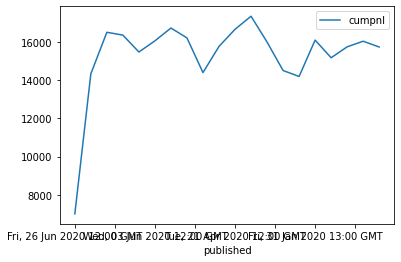

In [ ]:
import matplotlib.pyplot as plt
news_df.plot(x="published", y=["cumpnl"])

**Resources**

* [AltSignals.AI](https://www.altsignals.ai/)
* [Yfinance](https://pypi.org/project/yfinance/)
* [TextBlob](https://pypi.org/project/textblob/)
* [Vader Sentiment](https://pypi.org/project/vaderSentiment/)

